In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read the csv dataset
historical_data = pd.read_csv("historical_data.csv")
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [ ]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [ ]:
# created_at and actual_delivery_time is object but need to convert in datetime format 
# so that we can find the delivery duration(prediction value)
historical_data['created_at'] = pd.to_datetime(historical_data['created_at'])
historical_data['actual_delivery_time'] = pd.to_datetime(historical_data['actual_delivery_time'])
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

# Feature creation
 Target variable = actual delivery time - ordercreation time

In [ ]:
# Create the target variable as it is supervised problem
from datetime import datetime
historical_data['actual_total_delivery_duration'] = (historical_data['actual_delivery_time'] - historical_data['created_at']).dt.total_seconds()

### Available and busy dasher information 
* Total number of available dashers within a certain area will change from time to time so we will find the ratio 
* So the hypothesis: Higher the busy dashers ratio, lesser the dasher capacity. Hence, delivery duration will be longer

In [ ]:
historical_data['busy_dashers_ratio'] = historical_data['total_busy_dashers'] / historical_data['total_onshift_dashers']

In [ ]:
historical_data['estimated_non_prep_duration'] = historical_data['estimated_store_to_consumer_driving_duration'] + historical_data['estimated_order_place_duration']

## Data preparation for modeling

#### Check the nominal data collections and decide whether to encode or not
* Nominal features are: market_id, store_id, order_protocol 
* Do one-hot encoding for market_id and order_protocol as the categories are less

In [ ]:
historical_data['market_id'].nunique()

6

In [ ]:
historical_data['store_id'].nunique()

6743

In [ ]:
historical_data['order_protocol'].nunique()

7

In [ ]:
# Create dummies for market_id
market_id_dummies = pd.get_dummies(historical_data.market_id)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()

,market_id_1.0,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [ ]:
# Create dummies for order_protocol
order_protocol_dummies = pd.get_dummies(historical_data.order_protocol)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_1.0,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [ ]:
# Create dictionary with most repeated categories of each store to 
# fill null stores where it is possible
store_id_unique = historical_data['store_id'].unique().tolist()


In [ ]:
store_id_and_category = {store_id: historical_data[historical_data.store_id == store_id].store_primary_category.mode()
                        for store_id in store_id_unique}


In [ ]:
def fill(store_id):
    '''Return primary store category from the dictionary.'''
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan
    
# Fill the null values
historical_data['nan_free_store_primary_category'] = historical_data.store_id.apply(fill)


In [ ]:
# Create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(historical_data.nan_free_store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')
store_primary_category_dummies.head()

,category_afghan,category_african,category_alcohol,category_alcohol-plus-food,category_american,category_argentine,category_asian,category_barbecue,category_belgian,category_brazilian,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
historical_data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration,nan_free_store_primary_category
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0,american
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0,indian
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0,indian
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0,indian
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0,indian


In [ ]:
# Now, drop created_at, market_id, store_id, store_primary_category, 
# actual_delivery_time, actual_total_delivery_duration
train_df = historical_data.drop(columns = 
                               ['created_at', 'store_id', 'market_id', 'store_primary_category', 'actual_delivery_time', 'nan_free_store_primary_category', 'order_protocol'])
train_df.head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [ ]:
# Concatenate all the columns together
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)


In [ ]:
# convert the datatype into float for feature model sake
train_df = train_df.astype('float32')
train_df.head()


,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,1.0,0.0,0.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,1.0,1.0,2.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,6.0,6.0,9.0,446.0,650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,...,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000
mean,3.196391,2682.331543,2.670791,686.218506,1159.588623,44.808094,41.739746,58.050064,308.560181,545.358948,...,0.000815,0.000187,0.005465,0.011300,0.000740,0.037254,0.001175,0.001433,0.004234,0.030928
std,2.666546,1823.093750,1.630255,522.038635,558.411377,34.526787,32.145733,52.661831,90.139648,219.352905,...,0.028545,0.013689,0.073725,0.105701,0.027184,0.189384,0.034260,0.037834,0.064935,0.173122
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_df['busy_dashers_ratio'].describe()

count    1.775900e+05
mean              NaN
std               NaN
min              -inf
25%      8.269231e-01
50%      9.622642e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

In [ ]:
# Check infinity values with using numpy isfinite() function
np.where(np.any(~np.isfinite(train_df), axis=0)==True)

(array([ 5,  6,  7,  9, 10, 11, 12]),)

In [ ]:
# replace inf values with nan (droping nan value is simple)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nan values
train_df.dropna(inplace=True)

In [ ]:
train_df.shape

(177070, 100)

# Collinearity and Removing Redundancies
* Collinearity means that the varialbles are correlated with each other
* They have the same effect on the model
* It make it hard to interpret the model
#### Correlation Matrix: 
* A visual representation containing the correlation coefficients between the variables in the dataframe.


In [ ]:
# We will take only only one triangle because other triangle is only its symmetry 
# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

<Axes: >

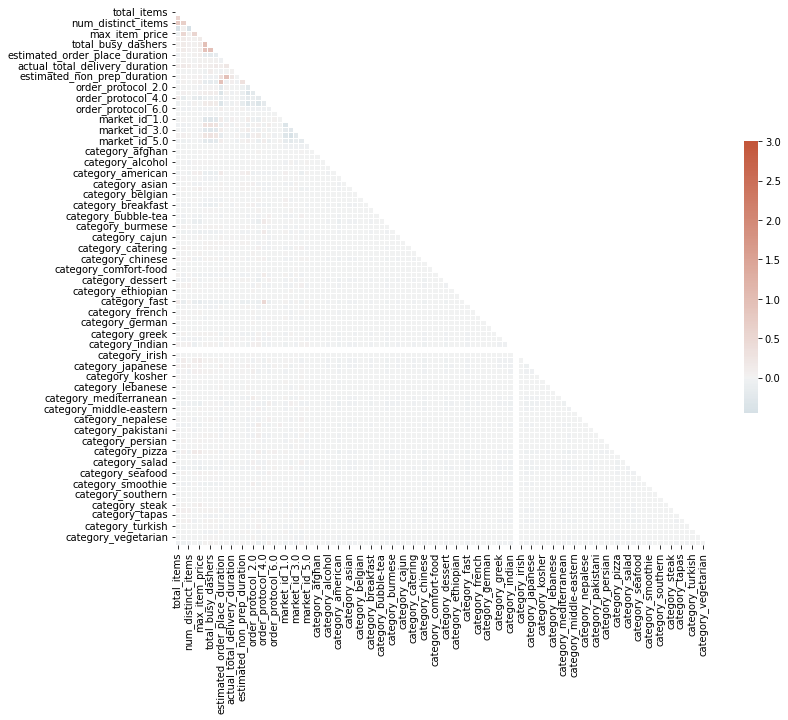

In [ ]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12,10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=3, center=0,
           square=True, linewidths=.5, cbar_kws={'shrink': .5})

In [ ]:
train_df['category_indonesian'].describe()

count    177070.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [ ]:
train_df.shape

(177070, 100)

## Two function to test the correlations:
1. Get Redundant values
2. Find top correlated features

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
    

In [ ]:
def get_top_abs_correlations(df, n=5):
    '''Sort correlations in the descending order and return n highest results'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]
    

In [ ]:
print("Top Absolute Correlations:")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations:
total_onshift_dashers                         total_busy_dashers             0.941741
                                              total_outstanding_orders       0.934639
total_busy_dashers                            total_outstanding_orders       0.931295
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.923086
estimated_order_place_duration                order_protocol_1.0             0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
order_protocol_4.0                            category_fast                  0.489946
num_distinct_items         

In [ ]:
train_df.shape

(177070, 100)

In [ ]:
# drop created_at, market_id, store_id, store_primary_category, 
# actual_delivery_time, actual_total_delivery_duration, order_protocol
train_df = historical_data.drop(columns = 
                               ['created_at', 'store_id', 'market_id', 'store_primary_category',
                                'actual_delivery_time', 'nan_free_store_primary_category', 'order_protocol'])
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,estimated_non_prep_duration
0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,0.424242,1307.0
1,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,2.000000,1136.0
2,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,0.000000,1136.0
3,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1.000000,735.0
4,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,1.000000,1096.0


In [ ]:
train_df.shape

(197428, 13)

In [ ]:
# don't concat market_id
train_df = pd.concat([train_df, order_protocol_dummies, store_primary_category_dummies], axis=1)


In [ ]:
# drop highly correlated features
train_df = train_df.drop(columns=['total_onshift_dashers',
                                 'total_busy_dashers',
                                 'category_indonesian',
                                 'estimated_non_prep_duration'])

In [ ]:
# align dtype over dataset
train_df = train_df.astype('float32')
# replace inf values with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# drop all nan values
train_df.dropna(inplace=True)

In [ ]:
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,21.0,446.0,861.0,3779.0,0.424242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,2.0,446.0,690.0,4024.0,2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1900.0,1.0,1900.0,1900.0,0.0,446.0,690.0,1781.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6900.0,5.0,600.0,1800.0,2.0,446.0,289.0,3075.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3900.0,3.0,1100.0,1600.0,9.0,446.0,650.0,2390.0,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_df.shape

(177070, 90)

In [ ]:
def get_top_abs_correlations(df, n=5):
    '''Sort correlations in the ascending order and return n highest results'''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations: ")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations: 
estimated_order_place_duration  order_protocol_1.0    0.897645
total_items                     num_distinct_items    0.758146
subtotal                        num_distinct_items    0.682890
total_items                     subtotal              0.557175
min_item_price                  max_item_price        0.541241
subtotal                        max_item_price        0.507947
order_protocol_4.0              category_fast         0.489946
num_distinct_items              min_item_price        0.446733
total_items                     min_item_price        0.389277
order_protocol_1.0              order_protocol_3.0    0.373581
estimated_order_place_duration  order_protocol_3.0    0.364170
order_protocol_1.0              order_protocol_5.0    0.342345
estimated_order_place_duration  order_protocol_5.0    0.333291
order_protocol_3.0              order_protocol_5.0    0.332533
order_protocol_1.0              order_protocol_2.0    0.226903
estimated_order_place_durat

In [ ]:
# Drop created_at, market_id, store_id, store_primary_category, actual_delivery_time, order_protocol
train_df = historical_data.drop(columns = ['created_at', 'market_id', 'store_id', 'store_primary_category', 'actual_delivery_time',
                                          'nan_free_store_primary_category', 'order_protocol'])
# Don't concat order_protocol_dummies
train_df = pd.concat([train_df, store_primary_category_dummies], axis=1)
train_df = train_df.drop(columns=['total_onshift_dashers', 'total_busy_dashers',
                                 'category_indonesian',
                                 'estimated_non_prep_duration'])
# align data type over dataset
train_df = train_df.astype('float32')
# replace inf values with nan
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop nan values
train_df.dropna(inplace=True)
train_df.head()

print("Top Absolute Correlations: ")
print(get_top_abs_correlations(train_df, 20))



Top Absolute Correlations: 
total_items                                   num_distinct_items                0.758146
subtotal                                      num_distinct_items                0.682890
total_items                                   subtotal                          0.557175
min_item_price                                max_item_price                    0.541241
subtotal                                      max_item_price                    0.507947
num_distinct_items                            min_item_price                    0.446733
total_items                                   min_item_price                    0.389277
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
subtotal                                      actual_total_delivery_duration    0.172312
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.

## Feature engineering
* It is a technique that create new variables to simplify the model and increase its accuracy by using the new variables as predictors

In [ ]:
# New Features
train_df['percent_distinct_item_of_total'] = train_df['num_distinct_items'] / train_df['total_items']
train_df['avg_price_per_item'] = train_df['subtotal'] / train_df['total_items']
train_df.drop(columns=['num_distinct_items', 'subtotal'], inplace=True)

print("Top Aboslute Correlations: ")
print(get_top_abs_correlations(train_df, 20))


Top Aboslute Correlations: 
min_item_price                                avg_price_per_item                0.860580
max_item_price                                avg_price_per_item                0.770382
min_item_price                                max_item_price                    0.541241
total_items                                   percent_distinct_item_of_total    0.445751
                                              min_item_price                    0.389277
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
max_item_price                                percent_distinct_item_of_total    0.178021
category_fast                                 avg_price_per_item                0.

In [ ]:
train_df['price_range_of_items'] = train_df['max_item_price'] - train_df['min_item_price']
train_df.drop(columns=['max_item_price', 'min_item_price'], inplace=True)

print("Top Aboslute Correlations: ")
print(get_top_abs_correlations(train_df, 20))

Top Aboslute Correlations: 
total_items                                   percent_distinct_item_of_total    0.445751
                                              price_range_of_items              0.333304
                                              avg_price_per_item                0.310759
percent_distinct_item_of_total                avg_price_per_item                0.226711
category_pizza                                avg_price_per_item                0.225510
estimated_store_to_consumer_driving_duration  actual_total_delivery_duration    0.188418
category_fast                                 avg_price_per_item                0.175950
total_outstanding_orders                      estimated_order_place_duration    0.171049
total_items                                   category_fast                     0.170988
category_italian                              avg_price_per_item                0.158193
total_outstanding_orders                      actual_total_delivery_duration    0.

In [ ]:
train_df.shape

(177070, 82)

# Remove multicollinearity
- Multiple variable is correlated with each other. It may cause overfitting problems
- we will use vif (Variance Inflation Factor) and remove the features that have a vif score of over 20. It detects the multi-collinearity in the regression analysis. It gives the score by measuring how much regression analysis is affected by collinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
def compute_vif(features):
    '''Compute VIF score using variance_inflation_factor() function'''
    vif_data = pd.DataFrame()
    vif_data['feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [ ]:
# Apply VIF computation to all columns
features = train_df.drop(columns=['actual_total_delivery_duration']).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000370
1,category_chocolate,1.000493
2,category_belgian,1.000754
3,category_russian,1.003228
4,category_african,1.003821
...,...,...
76,busy_dashers_ratio,6.369595
77,category_american,7.033604
78,estimated_store_to_consumer_driving_duration,7.210835
79,estimated_order_place_duration,13.472332


In [ ]:
multicollinearity = True

while multicollinearity:
    highest_vif_feature = vif_data['feature'].values.tolist()[-1]
    print("I will remove", highest_vif_feature)
    features.remove(highest_vif_feature)
    vif_data = compute_vif(features)
    multicollinearity = False if len(vif_data[vif_data.VIF > 20]) == 0 else True
    
selected_features = vif_data['feature'].values.tolist()
vif_data

I will remove percent_distinct_item_of_total


,feature,VIF
0,category_alcohol-plus-food,1.000222
1,category_chocolate,1.000366
2,category_belgian,1.000456
3,category_russian,1.002019
4,category_gluten-free,1.002367
...,...,...
75,category_american,4.505926
76,avg_price_per_item,5.958964
77,busy_dashers_ratio,6.357885
78,estimated_store_to_consumer_driving_duration,7.192635


## Feature selection
- Feature selection works to reduce the dimension of the dataset and giving rid of the features that do not have the significant effect on the model also it helps our algorithm to work faster.
- We can use PCA or Random Forest Regression method
###### Let's apply random forest with gini importance to measure the importance of each feature by using Genie's importance. Genie's importance calculates the features importance across all splits that random forest regressors do




In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Selected features are selected in multicollinearity check part
X = train_df[selected_features]
y = train_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


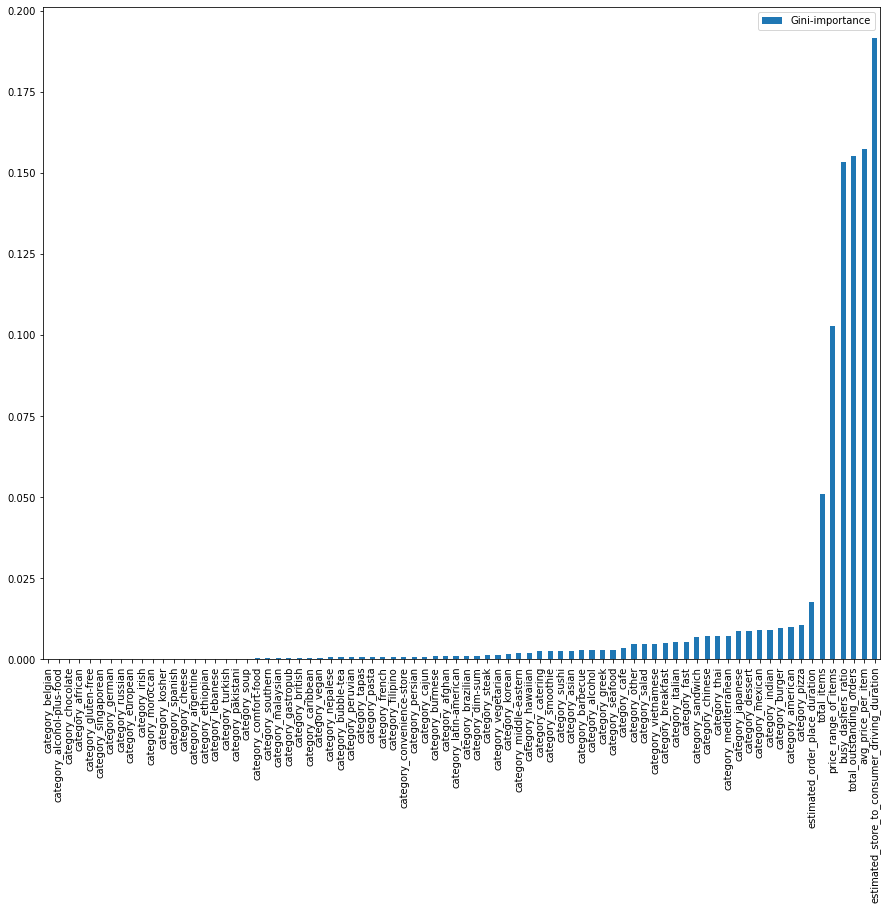

In [ ]:
feature_names = [f'feature{i}' for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # A dictonary to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance # add the name or value pair
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()
    

In [ ]:
# 35 highest Genie's importance
# we can obtain the column names as text
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_middle-eastern',
 'category_hawaiian',
 'category_catering',
 'category_smoothie',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_alcohol',
 'category_greek',
 'category_seafood',
 'category_cafe',
 'category_other',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_italian',
 'category_fast',
 'category_sandwich',
 'category_chinese',
 'category_thai',
 'category_mediterranean',
 'category_japanese',
 'category_dessert',
 'category_mexican',
 'category_indian',
 'category_burger',
 'category_american',
 'category_pizza',
 'estimated_order_place_duration',
 'total_items',
 'price_range_of_items',
 'busy_dashers_ratio',
 'total_outstanding_orders',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

<ipython-input-53-cfb58502784f>:11: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0,81,1)


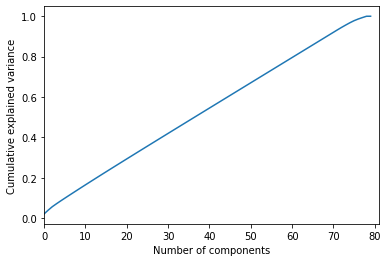

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train = X_train.values
X_Train = np.asarray(X_Train)

# Finding normalised array of X_Train
X_std = StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


Now the results tells us that by using 60 of the features the data set can be explained by 80

### Scaling (gradient descent works better after scaling)
##### 2 methods for scaling
- Standard scalar
- Min/Max scaling

Both StandardScaler and MinMaxScaler are commonly used data preprocessing techniques in machine learning to transform the input features to improve the performance of models.

StandardScaler scales the input data such that it has zero mean and unit variance. This means that the transformed data will have a mean of zero and a standard deviation of one. StandardScaler is useful when the features have different scales or units of measurement, and it is often used when the data is normally distributed.

MinMaxScaler scales the input data to a specified range, typically between 0 and 1. This means that the transformed data will have minimum value of 0 and maximum value of 1. MinMaxScaler is useful when the features have different minimum and maximum values, and it is often used when the data is not normally distributed.

In general, the choice of which scaler to use depends on the specific characteristics of the data and the requirements of the machine learning algorithm being used.



In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
def scale(scaler, X, y):
    '''Apply the selected scaler to features and target variables'''
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler


In [ ]:
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
X_scaled, y_scaled, test_size=0.2, random_state=42)


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_trainsform(scaler, y_test, y_pred_scaled, model_name):
    '''Convert the scaled error to actual error'''
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with sqared False
    rmse_error = mean_squared_error(y_test, y_predict[:, 0], squared=False)
    print("Error = "'{}'.format(rmse_error)+' in '+ model_name)
    return rmse_error, y_predict

# Modeling
We will apply:
- 6 different algorithms: that will help to find best performance model
- 4 different feature set sizes: full, 40, 20, 10 features(selected by Gini import)
- 3 different scalers: standard, min-max, no scaler

So, 6 algorithms, 4 features, 3 scalers = 72 individual result

In [ ]:
# Importing Machine Learning models
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
# Create a generic function which can work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    '''Apply selected regression model to data and measure error'''
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error) + ' in ' + model_name)
        print("Test error = "'{}'.format(test_error) + ' in ' + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error


In [ ]:
pred_dict = {
    'Regression_model': [],
    'Feature_set': [],
    'Scaler_name': [],
    'RMSE': [],
}

regression_models = {
    'Ridge' : linear_model.Ridge(),
    'DecisionTree' : tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest' : RandomForestRegressor(),
    'XGBoost' : XGBRegressor(),
    'LGBM' : LGBMRegressor(),
    'MLP' : MLPRegressor(),
}

feature_sets = {
    'Full dataset': X.columns.to_list(),
    'Selected_features_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    'Selected_features_20': importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    'Selected_features_10': importances.sort_values(by='Gini-importance')[-10:].index.tolist(),
}

scalers = {
    'Standard scaler': StandardScaler(),
    'MinMax scaler': MinMaxScaler(),
    'NotScale': None,
}


In [ ]:
# Examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df['actual_total_delivery_duration']
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
                
            else:
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
                rmse_error, y_predict = rmse_with_inv_trainsform(y_scaler, y_test, y_predict_scaled, model_name)
                
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are Full dataset

Train error = 0.767963171005249 in Ridge
Test error = 1.4719302654266357 in Ridge
Error = 2053.69873046875 in Ridge
Train error = 0.7653021361303404 in DecisionTree
Test error = 1.4744739559914226 in DecisionTree
Error = 2057.2476687088733 in DecisionTree
Train error = 0.283889216993677 in RandomForest
Test error = 1.4696194590069196 in RandomForest
Error = 2050.474471403711 in RandomForest
Train error = 0.6924042105674744 in XGBoost
Test error = 1.4594244956970215 in XGBoost
Error = 2036.2498779296875 in XGBoost
Train error = 0.7297768813103676 in LGBM
Test error = 1.4574073174711764 in LGBM
Error = 2033.4355809987908 in LGBM
Train error = 0.7427708506584167 in MLP
Test error = 1.4619296789169312 in MLP
Error = 2039.7457275390625 in MLP
-----scaled with MinMax scaler-------- included columns are Full dataset

Train error = 0.0032242187298834324 in Ridge
Test error = 0.006179544143378735 in Ridge
Error = 2053.9

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42532e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1071.4971923828125 in Ridge
Test error = 2053.692626953125 in Ridge
Train error = 1067.7815291116704 in DecisionTree
Test error = 2057.2476684096064 in DecisionTree
Train error = 397.6093939182471 in RandomForest
Test error = 2048.171412634449 in RandomForest
Train error = 968.2471313476562 in XGBoost
Test error = 2036.43212890625 in XGBoost
Train error = 1017.5549840201221 in LGBM
Test error = 2034.461097275308 in LGBM


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.38818359375 in MLP
Test error = 2048.257080078125 in MLP
-----scaled with Standard scaler-------- included columns are Selected_features_40

Train error = 0.7685800194740295 in Ridge
Test error = 1.4721492528915405 in Ridge
Error = 2054.00439453125 in Ridge
Train error = 0.7653050277966773 in DecisionTree
Test error = 1.4739590156893994 in DecisionTree
Error = 2056.5292024696128 in DecisionTree
Train error = 0.2841217942712195 in RandomForest
Test error = 1.4685593758405673 in RandomForest
Error = 2048.99539904011 in RandomForest
Train error = 0.6926604509353638 in XGBoost
Test error = 1.4588536024093628 in XGBoost
Error = 2035.453369140625 in XGBoost
Train error = 0.7293252740702356 in LGBM
Test error = 1.4582805119970572 in LGBM
Error = 2034.6538984910121 in LGBM
Train error = 0.7360899448394775 in MLP
Test error = 1.4588556289672852 in MLP
Error = 2035.45654296875 in MLP
-----scaled with MinMax scaler-------- included columns are Selected_features_40

Train error 

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.55923e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1067.785563647774 in DecisionTree
Test error = 2056.529202224364 in DecisionTree
Train error = 396.64064862267463 in RandomForest
Test error = 2048.0704505272843 in RandomForest
Train error = 965.6858520507812 in XGBoost
Test error = 2035.7642822265625 in XGBoost
Train error = 1017.1430421117441 in LGBM
Test error = 2034.8058530174258 in LGBM


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1055.2974853515625 in MLP
Test error = 2047.233154296875 in MLP
-----scaled with Standard scaler-------- included columns are Selected_features_20

Train error = 0.770122230052948 in Ridge
Test error = 1.4731249809265137 in Ridge
Error = 2055.36572265625 in Ridge
Train error = 0.7662722630951128 in DecisionTree
Test error = 1.4725837048094073 in DecisionTree
Error = 2054.610311207463 in DecisionTree
Train error = 0.2858088520372223 in RandomForest
Test error = 1.468647192794978 in RandomForest
Error = 2049.1179248995118 in RandomForest
Train error = 0.6905712485313416 in XGBoost
Test error = 1.4604161977767944 in XGBoost
Error = 2037.6336669921875 in XGBoost
Train error = 0.7301559207008418 in LGBM
Test error = 1.4592620523768804 in LGBM
Error = 2036.0233846729805 in LGBM
Train error = 0.7410908341407776 in MLP
Test error = 1.460201621055603 in MLP
Error = 2037.334228515625 in MLP
-----scaled with MinMax scaler-------- included columns are Selected_features_20

Train erro

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.43858e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1069.1350906055598 in DecisionTree
Test error = 2054.610311170708 in DecisionTree
Train error = 398.68088249772967 in RandomForest
Test error = 2049.1544206477556 in RandomForest
Train error = 966.1651000976562 in XGBoost
Test error = 2036.249267578125 in XGBoost
Train error = 1018.9600610110249 in LGBM
Test error = 2035.9494403356318 in LGBM


/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Train error = 1056.53076171875 in MLP
Test error = 2047.892822265625 in MLP
-----scaled with Standard scaler-------- included columns are Selected_features_10

Train error = 0.7717142105102539 in Ridge
Test error = 1.4739872217178345 in Ridge
Error = 2056.568359375 in Ridge
Train error = 0.7663420076820632 in DecisionTree
Test error = 1.4725742906448305 in DecisionTree
Error = 2054.5971761770547 in DecisionTree
Train error = 0.2875156853625718 in RandomForest
Test error = 1.4719920065287617 in RandomForest
Error = 2053.784748892063 in RandomForest
Train error = 0.6992177963256836 in XGBoost
Test error = 1.4623059034347534 in XGBoost
Error = 2040.27001953125 in XGBoost
Train error = 0.7331284482493243 in LGBM
Test error = 1.4607728842307477 in LGBM
Error = 2038.1313604554389 in LGBM
Train error = 0.7464436292648315 in MLP
Test error = 1.4622849225997925 in MLP
Error = 2040.2412109375 in MLP
-----scaled with MinMax scaler-------- included columns are Selected_features_10

Train error = 0

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Save pred_dict to the dataframe pred_df
pred_df = pd.DataFrame(pred_dict)
pred_df

,Regression_model,Feature_set,Scaler_name,RMSE
0,Ridge,Full dataset,Standard scaler,2053.698730
1,DecisionTree,Full dataset,Standard scaler,2057.247669
2,RandomForest,Full dataset,Standard scaler,2050.474471
3,XGBoost,Full dataset,Standard scaler,2036.249878
4,LGBM,Full dataset,Standard scaler,2033.435581
...,...,...,...,...
67,DecisionTree,Selected_features_10,NotScale,2076.165771
68,RandomForest,Selected_features_10,NotScale,2076.165771
69,XGBoost,Selected_features_10,NotScale,2076.165771
70,LGBM,Selected_features_10,NotScale,2076.165771


<Axes: >

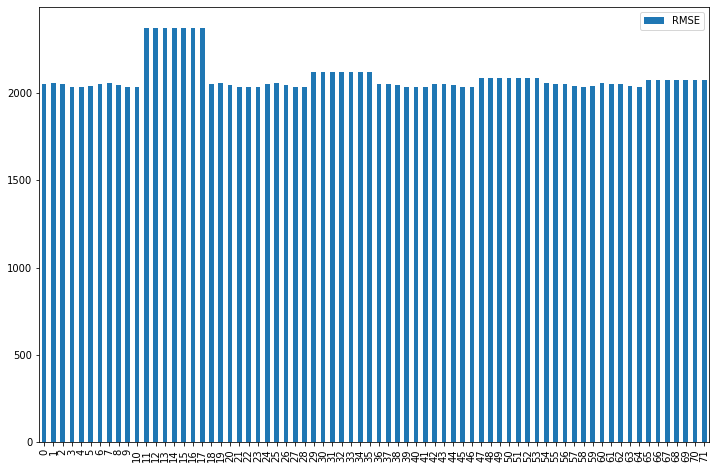

In [ ]:
# Using different sclar and feature size doesn't have much effect in the model so we are using 
# standard scaler and feature size 40

# bar plot
pred_df.plot(kind='bar', figsize=(12,8))

In [ ]:
# Let's change the problem: predict prep_duration and then calculate actual_total_delivery_duration
train_df['prep_time'] = train_df['actual_total_delivery_duration'] - train_df["estimated_store_to_consumer_driving_duration"] - train_df['estimated_order_place_duration']


In [ ]:
# Not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    'Selected_feature_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}


We have to drop two features becaues target variable is derived from these features and collinearity is avoided by dropping them upfront

In [ ]:
# Examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration',
                                                    'estimated_order_place_duration'])
            y = train_df['prep_time']

            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_trainsform(y_scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)


-----scaled with Standard scaler-------- included columns are Selected_feature_40

Train error = 0.786737859249115 in Ridge
Test error = 1.5045512914657593 in Ridge
Error = 2055.40771484375 in Ridge
Train error = 0.7693331400114065 in DecisionTree
Test error = 1.4976355980472322 in DecisionTree
Error = 2045.9600605629953 in DecisionTree
Train error = 0.29371230206608 in RandomForest
Test error = 1.504748139822595 in RandomForest
Error = 2055.676694811262 in RandomForest
Train error = 0.7115257978439331 in XGBoost
Test error = 1.4916772842407227 in XGBoost
Error = 2037.8203125 in XGBoost
Train error = 0.7484992880216514 in LGBM
Test error = 1.490142572482501 in LGBM
Error = 2035.7236370573405 in LGBM
Train error = 0.7584117650985718 in MLP
Test error = 1.4926093816757202 in MLP
Error = 2039.0938720703125 in MLP


In [ ]:
# Not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    'Selected_feature_40': importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# Continue with best performing model
regression_models = {
    'LGBM': LGBMRegressor(),
}

# Examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():
            # drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=['estimated_store_to_consumer_driving_duration',
                                                    'estimated_order_place_duration'])
            y = train_df['prep_time']

            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices = X_test.index

            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)

            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=True)
            rmse_error, y_predict = rmse_with_inv_trainsform(y_scaler, y_test, y_predict_scaled, model_name)
            
            pred_dict["Regression_model"].append(model_name)
            pred_dict["Feature_set"].append(feature_set_name)
            pred_dict["Scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)




-----scaled with Standard scaler-------- included columns are Selected_feature_40

Train error = 0.7484992880216514 in LGBM
Test error = 1.490142572482501 in LGBM
Error = 2035.7236370573405 in LGBM


In [ ]:
# Choose best perform model and extract the prediction for preparation duration
pred_values_dict = {
    'actual_total_delivery_duration': train_df['actual_total_delivery_duration'][test_indices].values.tolist(),
    'prep_duration_prediction': y_predict[:, 0].tolist(),
    'estimated_store_to_consumer_driving_duration': train_df['estimated_store_to_consumer_driving_duration'][test_indices].values.tolist(),
    'estimated_order_place_duration': train_df['estimated_order_place_duration'][test_indices].values.tolist(),
}

In [ ]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df 


,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration
0,2448.0,1734.115287,380.0,251.0
1,1839.0,1508.588146,747.0,446.0
2,1927.0,2141.085685,543.0,251.0
3,2657.0,1312.559865,445.0,251.0
4,3596.0,1945.871826,691.0,446.0
...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0
35410,1864.0,2148.159250,324.0,446.0
35411,2674.0,1939.286320,791.0,251.0
35412,2234.0,1930.656157,687.0,251.0


In [ ]:
# sum predictions up with non preparation activities such as order placing and driving
values_df['sum_total_delivery_duration'] = values_df['prep_duration_prediction'] + values_df['estimated_store_to_consumer_driving_duration'] + values_df['estimated_order_place_duration']
values_df


,actual_total_delivery_duration,prep_duration_prediction,estimated_store_to_consumer_driving_duration,estimated_order_place_duration,sum_total_delivery_duration
0,2448.0,1734.115287,380.0,251.0,2365.115287
1,1839.0,1508.588146,747.0,446.0,2701.588146
2,1927.0,2141.085685,543.0,251.0,2935.085685
3,2657.0,1312.559865,445.0,251.0,2008.559865
4,3596.0,1945.871826,691.0,446.0,3082.871826
...,...,...,...,...,...
35409,9557.0,2623.132706,768.0,446.0,3837.132706
35410,1864.0,2148.159250,324.0,446.0,2918.159250
35411,2674.0,1939.286320,791.0,251.0,2981.286320
35412,2234.0,1930.656157,687.0,251.0,2868.656157


In [ ]:
# Check new error rate
mean_squared_error(values_df['actual_total_delivery_duration'], values_df['sum_total_delivery_duration'], squared=False)


2035.7236370573405

In [ ]:
# What if we use another regression to obtain the actual total delivery duration
X = values_df[['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']]
y = values_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
regression_models = {
    'Ridge' : linear_model.Ridge(),
    'DecisionTree' : tree.DecisionTreeRegressor(max_depth=6),
    'RandomForest' : RandomForestRegressor(),
    'XGBoost' : XGBRegressor(),
    'LGBM' : LGBMRegressor(),
    'MLP' : MLPRegressor(),
}

for model_name in regression_models.keys():
    _, y_predict, _, _ = make_regression(
      X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=False)
    print("RMSE of: ", model_name, mean_squared_error(y_test, y_predict, squared=False))

RMSE of:  Ridge 986.6912510344928
RMSE of:  DecisionTree 1235.578088153976
RMSE of:  RandomForest 1330.3713530258556
RMSE of:  XGBoost 1370.412425918564
RMSE of:  LGBM 1079.2949179771774
RMSE of:  MLP 987.2227707525666


## Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense 
import tensorflow as tf
tf.random.set_seed(42)

def create_model(feature_set_size):
    # Define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='sgd', loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model
    



In [ ]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = 'ANN'
scaler_name = 'Standard scaler'
X = values_df[['prep_duration_prediction', 'estimated_store_to_consumer_driving_duration', 'estimated_order_place_duration']]
y = values_df['actual_total_delivery_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print('Feature_set_size: ', X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)   
y_pred = model.predict(X_test_scaled)
rmse_error= rmse_with_inv_trainsform(y_scaler, y_test, y_pred, model_name)

pred_dict["Regression_model"].append(model_name)
pred_dict["Feature_set"].append(feature_set_name)
pred_dict["Scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)       




-----scaled with Standard scaler-------- included columns are Selected_feature_40

Feature_set_size:  3
Epoch 1/100
443/443 [==============================] - 5s 3ms/step - loss: 1.1635 - root_mean_squared_error: 1.0787
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1219 - root_mean_squared_error: 1.0592
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1196 - root_mean_squared_error: 1.0581
Epoch 4/100
443/443 [==============================] - 2s 4ms/step - loss: 1.1192 - root_mean_squared_error: 1.0579
Epoch 5/100
443/443 [==============================] - 2s 3ms/step - loss: 1.1188 - root_mean_squared_error: 1.0577
Epoch 6/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1188 - root_mean_squared_error: 1.0577
Epoch 7/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1184 - root_mean_squared_error: 1.0576
Epoch 8/100
443/443 [==============================] - 1s 3ms/step - loss: 1.1182 - 

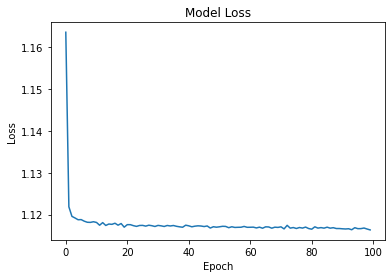

In [ ]:
# Graph about epoch vs loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()